In [54]:
import requests
import json

url = 'https://api.thevirustracker.com/free-api?countryTimeline=IT'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [55]:
import pandas as pd
import numpy as np

ITdata= pd.DataFrame(Data)
ITdata

,1/31/20,2/01/20,2/02/20,2/03/20,2/04/20,2/05/20,2/06/20,2/07/20,2/08/20,2/09/20,...,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,stat
new_daily_cases,2,0,0,0,0,0,0,1,0,0,...,190,128,280,306,252,274,254,168,202,ok
new_daily_deaths,0,0,0,0,0,0,0,0,0,0,...,13,15,9,10,5,5,5,5,11,ok
total_cases,2,2,2,2,2,2,2,3,3,3,...,244624,244752,245032,245338,245590,245864,246118,246286,246488,ok
total_recoveries,0,0,0,0,0,0,0,0,0,0,...,192815,192815,192815,192815,192815,192815,192815,192815,192815,ok
total_deaths,0,0,0,0,0,0,0,0,0,0,...,35058,35073,35082,35092,35097,35102,35107,35112,35123,ok


In [56]:
ITdata= pd.DataFrame(Data)
ITseries = ITdata.iloc[0].to_numpy()
ITseries = ITseries[:-1]
USseries = ITseries.astype('float32')
mean= np.mean(ITseries)
var= np.var(ITseries)
ITseries = ((ITseries - mean)/var)*1000
ITseries


array([-0.45072386, -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4510535 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.44577947, -0.4375388 , -0.42072785, -0.42699078,
       -0.42072785, -0.40820205, -0.3847986 , -0.37458017, -0.37227276,
       -0.26481456, -0.33865088, -0.2977772 , -0.25789243, -0.1979004 ,
       -0.19493376, -0.04033896,  0.04041952,  0.14095558, -0.12933809,
        0.31104282, -0.4513831 ,  1.2620151 ,  0.70132047,  0.73197573,
        0.6142991 ,  0.7108796 ,  0.93535525,  1.3028888 ,  1.5217607 ,
        1.7099774 ,  1.3813399 ,  1.1271979 ,  1.278826  ,  1.2659705 ,
        1.5932896 ,  1.4963795 ,  1.5178051 ,  1.268278  ,  0.8836039 ,
        0.8845928 ,  1.1248904 ,  1.087313  ,  1.059954  ,  1.1324718 ,
        0.9712845 ,  0.7349424 ,  0.5503516 ,  0.8130638 ,  0.93

In [57]:
ITtime = ITdata.columns.tolist()
ITtime = ITtime[:-1]


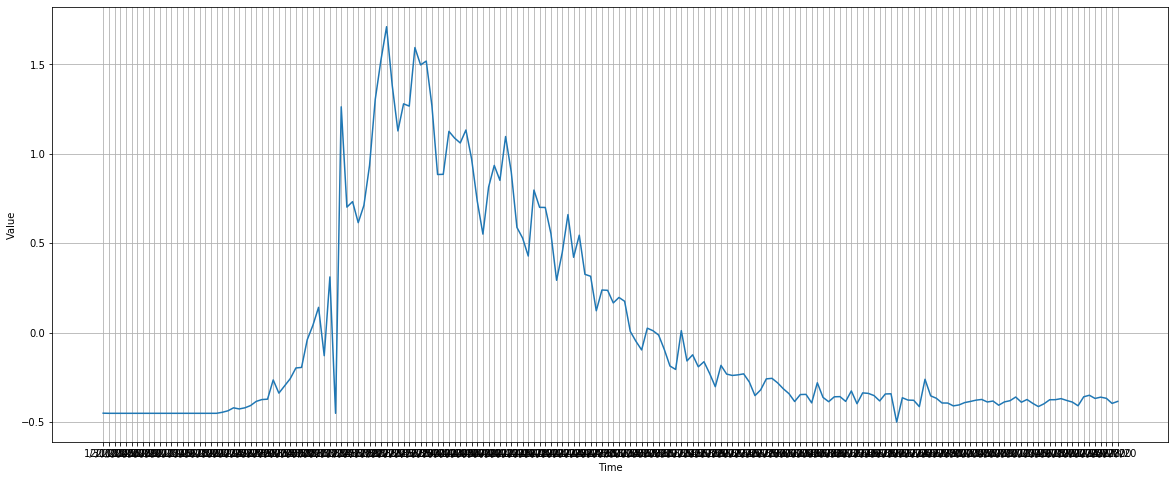

In [58]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(20, 8))
plot_series(ITtime,ITseries)

In [59]:
split_time = int(0.8 * ITseries.shape[0])
time_train = ITtime[:split_time]
x_train = ITseries[:split_time]
time_valid = ITtime[split_time:]
x_valid = ITseries[split_time:]

window_size = 10
batch_size = 5
shuffle_buffer_size = 500

In [60]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [61]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(5).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [62]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 64
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(next(iter(train_set.take(5))))
# print(x_train.shape)

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.LeakyReLU()
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)


Epoch 1/100
27/27 [==============================] - 9s 329ms/step - loss: 0.4963 - mae: 0.4969
Epoch 2/100
27/27 [==============================] - 1s 51ms/step - loss: 0.4963 - mae: 0.4969
Epoch 3/100
27/27 [==============================] - 2s 62ms/step - loss: 0.4963 - mae: 0.4969
Epoch 4/100
27/27 [==============================] - 2s 74ms/step - loss: 0.4963 - mae: 0.4969
Epoch 5/100
27/27 [==============================] - 1s 52ms/step - loss: 0.4963 - mae: 0.4969
Epoch 6/100
27/27 [==============================] - 2s 62ms/step - loss: 0.4963 - mae: 0.4969
Epoch 7/100
27/27 [==============================] - 2s 74ms/step - loss: 0.4963 - mae: 0.4969
Epoch 8/100
27/27 [==============================] - 2s 81ms/step - loss: 0.4963 - mae: 0.4969
Epoch 9/100
27/27 [==============================] - 2s 85ms/step - loss: 0.4963 - mae: 0.4969
Epoch 10/100
27/27 [==============================] - 2s 60ms/step - loss: 0.4963 - mae: 0.4969
Epoch 11/100
27/27 [============================

27/27 [==============================] - 1s 50ms/step - loss: 0.3352 - mae: 0.3359
Epoch 85/100
27/27 [==============================] - 1s 46ms/step - loss: 0.3102 - mae: 0.3108
Epoch 86/100
27/27 [==============================] - 1s 52ms/step - loss: 0.2999 - mae: 0.3005
Epoch 87/100
27/27 [==============================] - 2s 61ms/step - loss: 0.3677 - mae: 0.3687: 1s - loss: 0.5
Epoch 88/100
27/27 [==============================] - 2s 58ms/step - loss: 0.3114 - mae: 0.3122
Epoch 89/100
27/27 [==============================] - 1s 42ms/step - loss: 0.3641 - mae: 0.3651
Epoch 90/100
27/27 [==============================] - 2s 66ms/step - loss: 0.3079 - mae: 0.3088
Epoch 91/100
27/27 [==============================] - 2s 58ms/step - loss: 0.3113 - mae: 0.3124
Epoch 92/100
27/27 [==============================] - 2s 58ms/step - loss: 0.2942 - mae: 0.2948
Epoch 93/100
27/27 [==============================] - 2s 64ms/step - loss: 0.3051 - mae: 0.3061
Epoch 94/100
27/27 [=================

(5.655877526068171e-09,
 0.0015757960743081156,
 0.24490981408770185,
 0.5089507868999977)

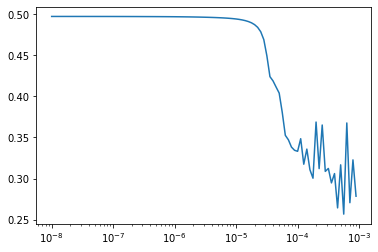

In [63]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

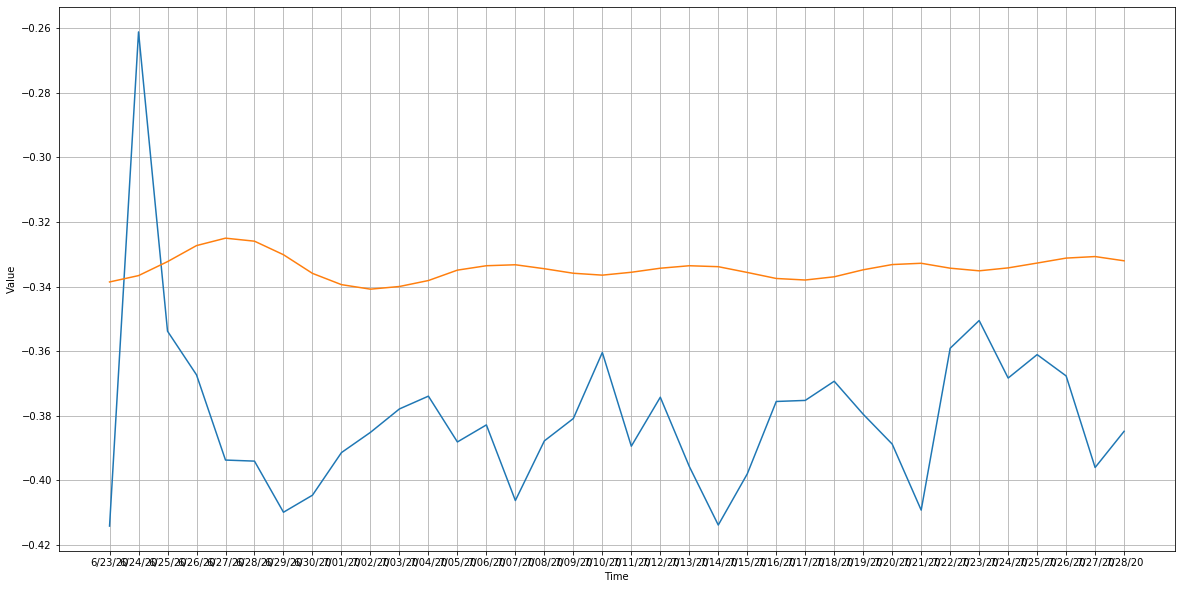

In [64]:
# plotting validation of ITALY
rnn_forecast = model_forecast(model, ITseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

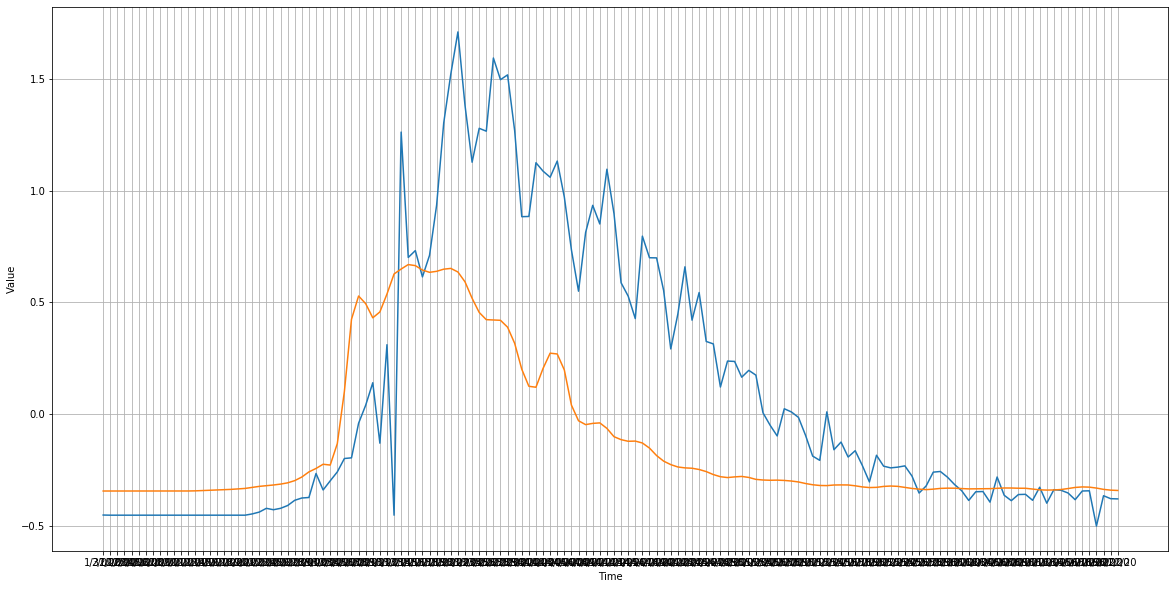

In [65]:
# plotting traning of ITALY
rnn_forecast = model_forecast(model, USseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)

In [66]:
url = 'https://api.thevirustracker.com/free-api?countryTimeline=EG'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [67]:
EGdata= pd.DataFrame(Data)
EGdata

,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,...,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,stat
new_daily_cases,1,0,0,0,0,0,0,0,0,0,...,627,676,667,668,659,511,479,420,465,ok
new_daily_deaths,0,0,0,0,0,0,0,0,0,0,...,50,47,41,40,38,40,48,46,39,ok
total_cases,1,1,1,1,1,1,1,1,1,1,...,88402,89078,89745,90413,91072,91583,92062,92482,92947,ok
total_recoveries,0,0,0,0,0,0,0,0,0,0,...,21718,21718,21718,21718,21718,21718,21718,21718,21718,ok
total_deaths,0,0,0,0,0,0,0,0,0,0,...,4352,4399,4440,4480,4518,4558,4606,4652,4691,ok


In [68]:
EGdata= pd.DataFrame(Data)
EGseries = EGdata.iloc[0].to_numpy()
EGseries = EGseries[:-1]
EGseries = EGseries.astype('float32')
mean= np.mean(EGseries)
var= np.var(EGseries)
EGseries = ((EGseries - mean)/var)*1000
EGseries

array([-1.7849033 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7849033 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7849033 , -1.749775  , -1.7880968 , -1.6795185 , -1.7689358 ,
       -1.7753228 , -1.7849033 , -1.7657423 , -1.7465816 , -1.695486  ,
       -1.7849033 , -1.6603576 , -1.6411967 , -1.7880968 , -1.596488  ,
       -1.695486  , -1.7593554 , -1.682712  , -1.6635511 , -1.6731316 ,
       -1.615649  , -1.6635511 , -1.6571642 , -1.6603576 , -1.682712  ,
       -1.6380032 , -1.615649  , -1.5677469 , -1.5134578 , -1.4048795 ,
       -1.5166513 , -1.4591687 , -1.3122686 , -1.3793317 , -1.4368143 ,
       -1.3442035 , -1.4847164 , -1.3250426 , -1.3857187 , -1.3889121 ,
       -1.2771405 , -1.2931079 , -1.2515926 , -1.2420123 , -1.1877232 ,
       -1.4304273 , -1.1845297 , -1.2867209 , -1.2483991 , -1.04

In [69]:
EGtime = EGdata.columns.tolist()
EGtime = EGtime[:-1]


In [70]:
split_time = int(0.95 * EGseries.shape[0])
time_train = EGtime[:split_time]
x_train = EGseries[:split_time]
time_valid = EGtime[split_time:]
x_valid = EGseries[split_time:]


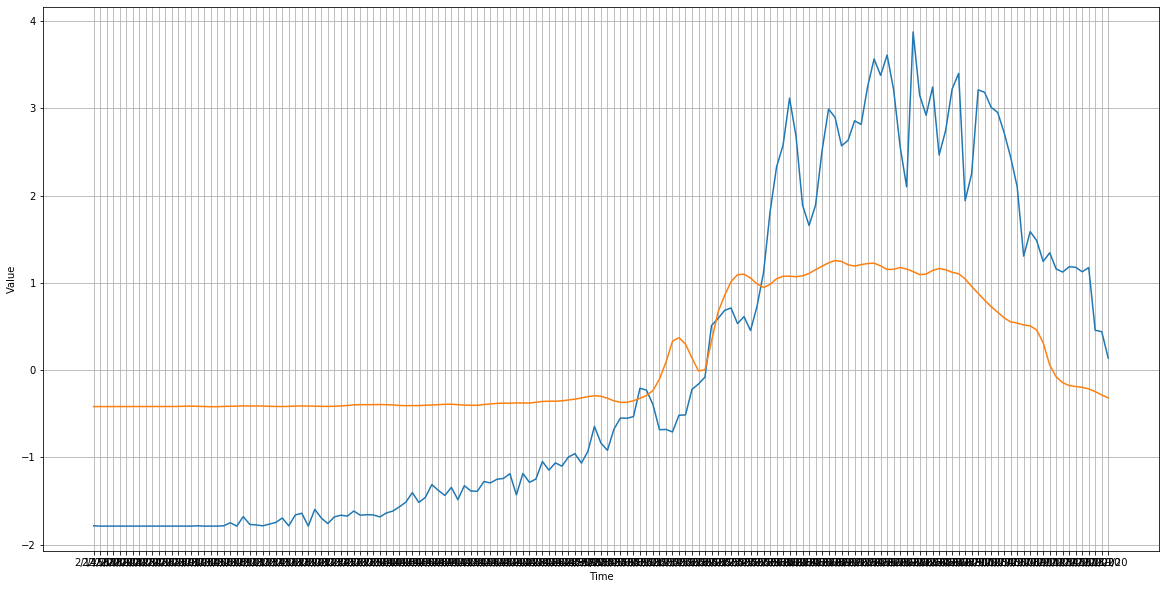

In [71]:
# plotting Egypt prediction for Italy model
rnn_forecast = model_forecast(model, EGseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)

In [ ]:
# Transfar learning 

